In [2]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
import cartopy.crs as ccrs
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, u_darrays as uda, u_arrays as ua
import datetime
import matplotlib.colors as mcolors
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from utils import u_plot as uplot
import salem
import numpy.ma as ma
from scipy import stats
import warnings

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [23]:
def corr(a, b, bsingle=None, c_box=None):
    ds = xr.Dataset()
    #ipdb.set_trace()
    ds['pval'] = a.copy(deep=True).sum('time') * np.nan
    ds['r'] = a.copy(deep=True).sum('time') * np.nan
    ds['slope'] = a.copy(deep=True).sum('time') * np.nan
    ds['intercept'] = a.copy(deep=True).sum('time') * np.nan

    corr_box = c_box
    perPixel = False
    if bsingle:
        bb = b
    elif c_box:
        bb = b.sel(latitude=slice(corr_box[2], corr_box[3]), longitude=slice(corr_box[0], corr_box[1])).mean(dim=['latitude', 'longitude'])
    else:
        perPixel=True


    for lat in a.latitude.values:
        for lon in a.longitude.values:
            aa = a.sel(latitude=lat, longitude=lon)
            if bsingle:
                r, p = stats.pearsonr(aa.values, bb)

                #pf = np.polyfit(aa.values, bb, 1)
                pf, intercept, r, p, std_err = stats.linregress(aa.values, bb)
            elif c_box:
                # r, p = stats.pearsonr(aa.values, bb.values)
                # pf = np.polyfit(aa.values, bb.values, 1)
                pf, intercept, r, p, std_err = stats.linregress(aa.values, bb.values)
            elif perPixel:
                bb = b.sel(latitude=lat, longitude=lon)
                pf, intercept, r, p, std_err = stats.linregress(aa.values, bb.values)


            slope = pf#[0]

            if (np.nansum(aa.values == 0) >= 10):
                p = np.nan
                r = np.nan
            #ipdb.set_trace()
            ds['r'].loc[{'latitude': lat, 'longitude': lon}] = r
            ds['pval'].loc[{'latitude': lat, 'longitude': lon}] = p
            ds['slope'].loc[{'latitude': lat, 'longitude': lon}] = slope
            ds['intercept'].loc[{'latitude': lat, 'longitude': lon}] = intercept

    return ds

In [4]:
fpath = cnst.network_data + 'figs/HUARAZ/'

In [5]:
    def array_juggling(data, month, hour=None):

        m = month

        if hour is not None:
            if len(month) > 1:

                data = data[((data['time.month'] >= month[0]) | (data['time.month'] <= month[1])) & (
                            data['time.hour'] == hour) & (data['time.year'] >= 1983) & (data['time.year'] <= 2018)]
            else:

                data = data[
                    (data['time.month'] == month[0]) & (data['time.hour'] == hour) & (data['time.year'] >= 1983) & (
                                data['time.year'] <= 2018)]
        else:
            if len(month) > 1:
                data = data[((data['time.month'] >= month[0]) | (data['time.month'] <= month[1])) & (
                            data['time.year'] >= 1983) & (data['time.year'] <= 2018)]
            else:
                data = data[
                    (data['time.month'] == month[0]) & (data['time.year'] >= 1983) & (data['time.year'] <= 2018)]

        data_years = data.groupby('time.year').mean(axis=0)

        data_mean = data.mean(axis=0)

        # diff = xr.DataArray(data_years.values[1::, :, :] - data_years.values[0:-1, :, :],
        #                     coords=[data_years.year[1::], data.latitude, data.longitude], dims=['year','latitude', 'longitude'] )
        diff = xr.DataArray(data_years.values, coords=[data_years.year, data.latitude, data.longitude],
                            dims=['year', 'latitude', 'longitude'])
        # unstack back to lat lon coordinates
        return diff, data_mean


In [6]:
date = '2016-01-13'
dt = pd.to_datetime(date)

In [50]:
u200orig = xr.open_dataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/u_15UTC_1981-2019_peru_big.nc')
# u200orig = xr.open_mfdataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/uv_15UTC/*.nc')
# u200orig = u200orig['u'].sel(level=250).load()
# u200orig.to_netcdf('/media/ck/Elements/SouthAmerica/ERA5/hourly/u_15UTC_1981-2019_peru_big.nc')

In [51]:
datetimes = pd.to_datetime(u200orig.time.values)

In [52]:
newtimes = []
for t in datetimes:
     newtimes.append(t.replace(hour=0))

In [53]:
u200orig['time'] = ('time', newtimes)

In [54]:
u200orig

<xarray.Dataset>
Dimensions:    (latitude: 125, longitude: 97, time: 14610)
Coordinates:
  * longitude  (longitude) float32 -82.0 -81.75 -81.5 ... -58.5 -58.25 -58.0
  * latitude   (latitude) float32 6.0 5.75 5.5 5.25 ... -24.5 -24.75 -25.0
    level      int32 ...
  * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2018-12-31
Data variables:
    u          (time, latitude, longitude) float32 ...

In [9]:
chirpsbox = [-81,-68,-17,0]
u200 = u200orig.sel(longitude=slice(chirpsbox[0], chirpsbox[1]), latitude=slice(chirpsbox[3], chirpsbox[2]))
u200orig = u200orig.sel(time=(u200orig['time.year']>1982))

In [14]:
chirps_all = xr.open_dataset('/home/ck/DIR/mymachine/CHIRPS/peru/CHIRPS_peru_onERA5.nc')

In [55]:
gridsat = xr.open_mfdataset('/home/ck/DIR/mymachine/GRIDSAT/MCS18_peru/daily_ALLkm2_UTC_DAY_onBIGERA/*.nc', combine='nested', concat_dim='time').load()

In [16]:
topo = xr.open_dataarray(cnst.TOPO_1MIN).sel(lon=slice(-83,-55), lat=slice(-26,7))

In [11]:
pos = np.intersect1d(chirps_all.time, u200.time)

NameError: name 'chirps_all' is not defined

In [56]:
posgrid =  np.intersect1d(u200orig.time.values,gridsat.time.values)

In [57]:
chirps = chirps_all.sel(time=pos)

NameError: name 'chirps_all' is not defined

In [58]:
u200orig = u200orig.sel(time=posgrid)

In [59]:
u200 = u200.sel(time=pos)

NameError: name 'pos' is not defined

In [15]:
gridsat = gridsat.sel(time=posgrid)

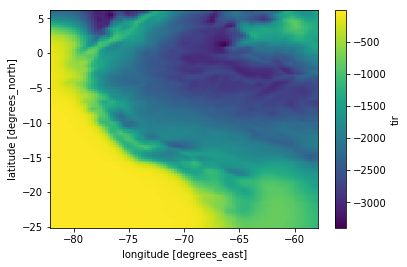

In [23]:
gridsat['tir'].mean('time').plot()

In [70]:
gridsat

<xarray.Dataset>
Dimensions:    (latitude: 125, longitude: 97, time: 12633)
Coordinates:
  * latitude   (latitude) float32 -25.0 -24.75 -24.5 -24.25 ... 5.5 5.75 6.0
  * longitude  (longitude) float32 -82.0 -81.75 -81.5 ... -58.5 -58.25 -58.0
  * time       (time) datetime64[ns] 1984-01-01 1984-01-02 ... 2018-12-31
Data variables:
    tir        (time, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    pyproj_srs:  +proj=longlat +datum=WGS84 +no_defs

In [22]:
topo_on_g = gridsat.salem.lookup_transform(topo)

In [106]:
u200_short = u200orig.sel(time=((u200orig['time.year']>=1990)&(u200orig['time.year']<=1992)))
gridsat_short = gridsat.sel(time=((gridsat['time.year']>=1990)&(gridsat['time.year']<=1992)))/100

In [107]:
u200_short

<xarray.Dataset>
Dimensions:    (latitude: 125, longitude: 97, time: 1096)
Coordinates:
  * longitude  (longitude) float32 -82.0 -81.75 -81.5 ... -58.5 -58.25 -58.0
  * latitude   (latitude) float32 6.0 5.75 5.5 5.25 ... -24.5 -24.75 -25.0
    level      int32 ...
  * time       (time) datetime64[ns] 1990-01-01 1990-01-02 ... 1992-12-31
Data variables:
    u          (time, latitude, longitude) float32 ...

In [113]:
u200_short.time[260:515]

<xarray.DataArray 'time' (time: 255)>
array(['1990-09-18T00:00:00.000000000', '1990-09-19T00:00:00.000000000',
       '1990-09-20T00:00:00.000000000', ..., '1991-05-28T00:00:00.000000000',
       '1991-05-29T00:00:00.000000000', '1991-05-30T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    level    int32 ...
  * time     (time) datetime64[ns] 1990-09-18 1990-09-19 ... 1991-05-30

In [114]:
# r = u200_short.copy(deep=True)
# r.values = np.nan
# r = r.rename({'u', 'r'})
# p = u200_short.copy(deep=True)
# p.values = np.nan
# p = p.rename('u', 'pval')
r = []
for ids, tt in enumerate(u200_short.time[260:515]):
    #ipdb.set_trace()
    print('Doing', tt)
    dt = pd.to_datetime(tt.values)
    window1 = dt - pd.Timedelta('10days')
    window2 = dt + pd.Timedelta('10days')
    
    bb = u200_short['u'].sel(time=slice(window1, window2))
    aa = gridsat['tir'].sel(time=slice(window1, window2))
    
    #ipdb.set_trace()

    carr = corr(aa, bb)
    r.append(carr)

Doing <xarray.DataArray 'time' ()>
array('1990-09-18T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    level    int32 ...
    time     datetime64[ns] 1990-09-18


/home/ck/miniconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/ck/miniconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


Doing <xarray.DataArray 'time' ()>
array('1990-09-19T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    level    int32 ...
    time     datetime64[ns] 1990-09-19
Doing <xarray.DataArray 'time' ()>
array('1990-09-20T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    level    int32 ...
    time     datetime64[ns] 1990-09-20
Doing <xarray.DataArray 'time' ()>
array('1990-09-21T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    level    int32 ...
    time     datetime64[ns] 1990-09-21
Doing <xarray.DataArray 'time' ()>
array('1990-09-22T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    level    int32 ...
    time     datetime64[ns] 1990-09-22
Doing <xarray.DataArray 'time' ()>
array('1990-09-23T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    level    int32 ...
    time     datetime64[ns] 1990-09-23
Doing <xarray.DataArray 'time' ()>
array('1990-09-24T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    level    int32 ...
 

Doing <xarray.DataArray 'time' ()>
array('1990-11-06T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    level    int32 ...
    time     datetime64[ns] 1990-11-06
Doing <xarray.DataArray 'time' ()>
array('1990-11-07T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    level    int32 ...
    time     datetime64[ns] 1990-11-07
Doing <xarray.DataArray 'time' ()>
array('1990-11-08T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    level    int32 ...
    time     datetime64[ns] 1990-11-08
Doing <xarray.DataArray 'time' ()>
array('1990-11-09T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    level    int32 ...
    time     datetime64[ns] 1990-11-09
Doing <xarray.DataArray 'time' ()>
array('1990-11-10T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    level    int32 ...
    time     datetime64[ns] 1990-11-10
Doing <xarray.DataArray 'time' ()>
array('1990-11-11T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    level    int32 ...
 

Doing <xarray.DataArray 'time' ()>
array('1990-12-24T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    level    int32 ...
    time     datetime64[ns] 1990-12-24
Doing <xarray.DataArray 'time' ()>
array('1990-12-25T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    level    int32 ...
    time     datetime64[ns] 1990-12-25
Doing <xarray.DataArray 'time' ()>
array('1990-12-26T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    level    int32 ...
    time     datetime64[ns] 1990-12-26
Doing <xarray.DataArray 'time' ()>
array('1990-12-27T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    level    int32 ...
    time     datetime64[ns] 1990-12-27
Doing <xarray.DataArray 'time' ()>
array('1990-12-28T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    level    int32 ...
    time     datetime64[ns] 1990-12-28
Doing <xarray.DataArray 'time' ()>
array('1990-12-29T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    level    int32 ...
 

Doing <xarray.DataArray 'time' ()>
array('1991-02-10T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    level    int32 ...
    time     datetime64[ns] 1991-02-10
Doing <xarray.DataArray 'time' ()>
array('1991-02-11T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    level    int32 ...
    time     datetime64[ns] 1991-02-11
Doing <xarray.DataArray 'time' ()>
array('1991-02-12T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    level    int32 ...
    time     datetime64[ns] 1991-02-12
Doing <xarray.DataArray 'time' ()>
array('1991-02-13T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    level    int32 ...
    time     datetime64[ns] 1991-02-13
Doing <xarray.DataArray 'time' ()>
array('1991-02-14T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    level    int32 ...
    time     datetime64[ns] 1991-02-14
Doing <xarray.DataArray 'time' ()>
array('1991-02-15T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    level    int32 ...
 

Doing <xarray.DataArray 'time' ()>
array('1991-03-30T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    level    int32 ...
    time     datetime64[ns] 1991-03-30
Doing <xarray.DataArray 'time' ()>
array('1991-03-31T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    level    int32 ...
    time     datetime64[ns] 1991-03-31
Doing <xarray.DataArray 'time' ()>
array('1991-04-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    level    int32 ...
    time     datetime64[ns] 1991-04-01
Doing <xarray.DataArray 'time' ()>
array('1991-04-02T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    level    int32 ...
    time     datetime64[ns] 1991-04-02
Doing <xarray.DataArray 'time' ()>
array('1991-04-03T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    level    int32 ...
    time     datetime64[ns] 1991-04-03
Doing <xarray.DataArray 'time' ()>
array('1991-04-04T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    level    int32 ...
 

Doing <xarray.DataArray 'time' ()>
array('1991-05-17T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    level    int32 ...
    time     datetime64[ns] 1991-05-17
Doing <xarray.DataArray 'time' ()>
array('1991-05-18T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    level    int32 ...
    time     datetime64[ns] 1991-05-18
Doing <xarray.DataArray 'time' ()>
array('1991-05-19T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    level    int32 ...
    time     datetime64[ns] 1991-05-19
Doing <xarray.DataArray 'time' ()>
array('1991-05-20T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    level    int32 ...
    time     datetime64[ns] 1991-05-20
Doing <xarray.DataArray 'time' ()>
array('1991-05-21T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    level    int32 ...
    time     datetime64[ns] 1991-05-21
Doing <xarray.DataArray 'time' ()>
array('1991-05-22T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    level    int32 ...
 

In [95]:
merged = xr.concat(r,dim=u200_short.time[260:515])

In [96]:
merged

<xarray.Dataset>
Dimensions:    (latitude: 125, longitude: 97, time: 20)
Coordinates:
  * time       (time) datetime64[ns] 1990-12-12 1990-12-13 ... 1990-12-31
  * latitude   (latitude) float32 -25.0 -24.75 -24.5 -24.25 ... 5.5 5.75 6.0
  * longitude  (longitude) float32 -82.0 -81.75 -81.5 ... -58.5 -58.25 -58.0
    level      int32 ...
Data variables:
    pval       (time, latitude, longitude) float64 nan nan nan ... nan nan nan
    r          (time, latitude, longitude) float64 nan nan nan ... nan nan nan
    slope      (time, latitude, longitude) float64 nan nan ... -0.001218
    intercept  (time, latitude, longitude) float64 nan nan nan ... 8.59 8.183

/home/ck/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


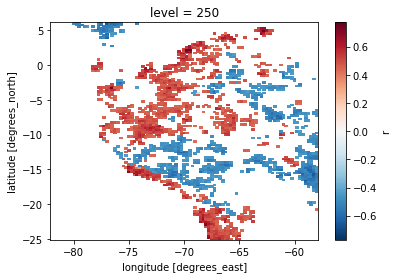

In [100]:
merged['r'].where(merged['pval']<=0.05).mean('time').plot()

In [71]:
cdoy = chirps.rolling(time=3, min_periods=1, center=True).mean(dim='time')
udoy = u200.rolling(time=3, min_periods=1, center=True).mean(dim='time')
ugdoy = u200orig#.rolling(time=3, min_periods=1, center=True).mean(dim='time')
gdoy = gridsat#.rolling(time=3, min_periods=1, center=True).mean(dim='time')

In [34]:
udoy

<xarray.Dataset>
Dimensions:    (latitude: 69, longitude: 53, time: 13879)
Coordinates:
  * longitude  (longitude) float32 -81.0 -80.75 -80.5 ... -68.5 -68.25 -68.0
  * latitude   (latitude) float32 0.0 -0.25 -0.5 -0.75 ... -16.5 -16.75 -17.0
    level      int32 250
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2018-12-31
Data variables:
    u          (time, latitude, longitude) float32 -2.464323 ... -6.1706877

In [35]:
cdoy

<xarray.Dataset>
Dimensions:    (latitude: 69, longitude: 53, time: 13879)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2018-12-31
  * longitude  (longitude) float32 -81.0 -80.75 -80.5 ... -68.5 -68.25 -68.0
  * latitude   (latitude) float32 -17.0 -16.75 -16.5 -16.25 ... -0.5 -0.25 0.0
Data variables:
    precip     (time, latitude, longitude) float32 nan nan ... 3.671646e-05 nan

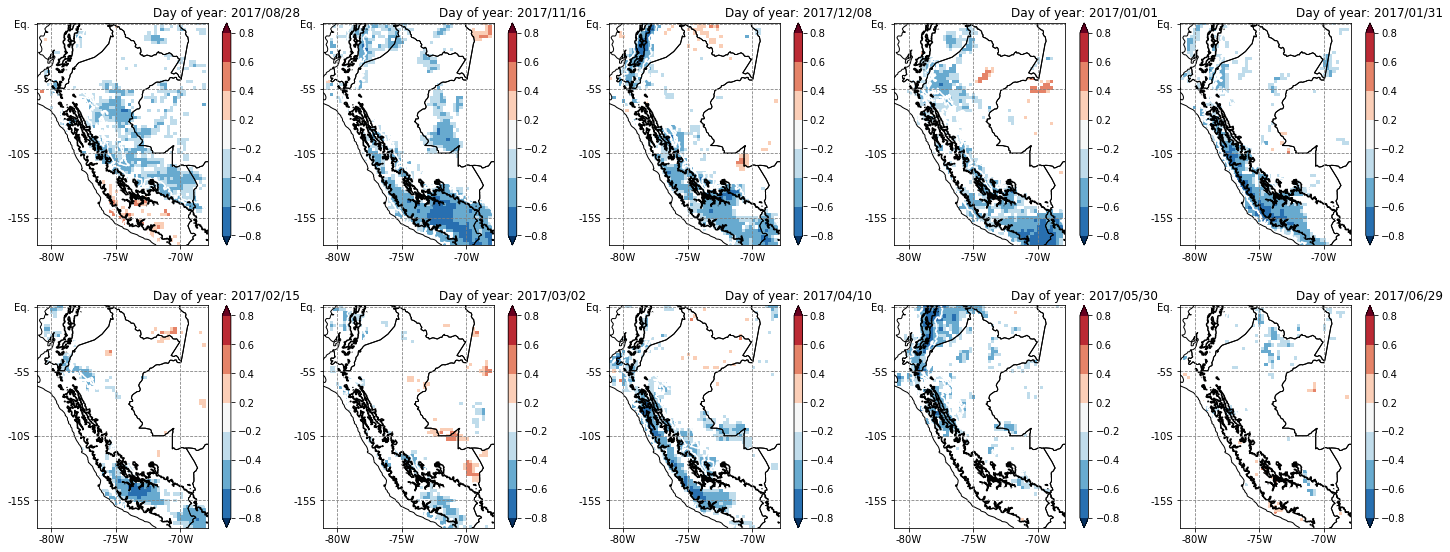

In [36]:
map = cdoy.salem.get_map()
f = plt.figure(figsize=(20,8))
for ids, d in enumerate([240,320,342,1,31,46,61,100,150,180]):
    ccdoy = cdoy['precip'].sel(time=(cdoy['time.dayofyear']==d))
    uudoy = udoy['u'].sel(time=(udoy['time.dayofyear']==d))
    
    diff1 = xr.DataArray(ccdoy.values[1::, :, :] - ccdoy.values[0:-1, :, :],
                 coords=[ccdoy.time[1::], ccdoy.latitude, ccdoy.longitude], dims=['time','latitude', 'longitude'] )
    diff2 = xr.DataArray(uudoy.values[1::, :, :] - uudoy.values[0:-1, :, :],
                 coords=[uudoy.time[1::], uudoy.latitude, uudoy.longitude], dims=['time','latitude', 'longitude'] )
    
    outarr = corr(diff1, diff2)
    
    date = pd.datetime(2017, 1, 1) + pd.Timedelta(str(d - 1)+' days')
    dstr = date.strftime("%Y/%m/%d")
    
    ax = f.add_subplot(2,5,ids+1)
    oarr = outarr['r'].where(outarr['pval']<=0.05)
    map.set_data(oarr)
    map.set_plot_params(levels=[-0.8,-0.6,-0.4,-0.2,0.2,0.4,0.6,0.8], cmap='RdBu_r', extend='both')
    map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys')
    map.visualize()

    plt.plot(-77.5, -9.5, 'ro')
    plt.title('Day of year: '+str(dstr))
plt.tight_layout()

In [40]:
dslist = []
for ids, d in enumerate(np.arange(1,6)):  #366
    ccdoy = cdoy['precip'].sel(time=(cdoy['time.dayofyear']==d))
    uudoy = udoy['u'].sel(time=(udoy['time.dayofyear']==d))
    
    #ipdb.set_trace()
    
    diff1 = xr.DataArray(ccdoy.values[1::, :, :] - ccdoy.values[0:-1, :, :],
                 coords=[ccdoy.time[1::], ccdoy.latitude, ccdoy.longitude], dims=['time','latitude', 'longitude'] )
    diff2 = xr.DataArray(uudoy.values[1::, :, :] - uudoy.values[0:-1, :, :],
                 coords=[uudoy.time[1::], uudoy.latitude, uudoy.longitude], dims=['time','latitude', 'longitude'] )
    
    outarr = corr(diff1, diff2)
    dslist.append(outarr)
chirps_ds = xr.concat(dslist, dim='dayofyear')
chirps_ds.to_netcdf('/home/ck/DIR/mymachine/CHIRPS/peru/CHIRPS_u200_correlation_peru.nc')

/home/ck/miniconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/ck/miniconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/ck/miniconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/ck/miniconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/ck/miniconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/ck/miniconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common

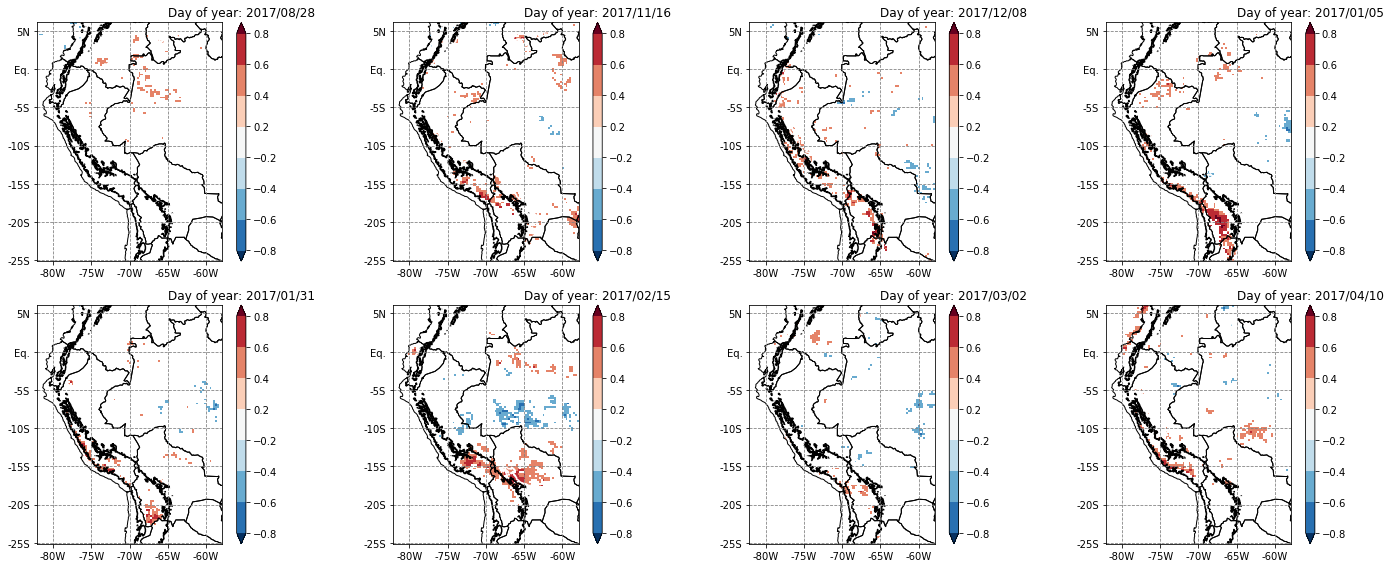

In [74]:
map = gdoy.salem.get_map()
f = plt.figure(figsize=(20,8))
for ids, d in enumerate([240,320,342,5,31,46,61,100]):
    ggdoy = gdoy['tir'].sel(time=(gdoy['time.dayofyear']==d))
    uudoy = ugdoy['u'].sel(time=(ugdoy['time.dayofyear']==d))
    
    diff1 = xr.DataArray(ggdoy.values[1::, :, :] - ggdoy.values[0:-1, :, :],
                 coords=[ggdoy.time[1::], ggdoy.latitude, ggdoy.longitude], dims=['time','latitude', 'longitude'] )
    diff2 = xr.DataArray(uudoy.values[1::, :, :] - uudoy.values[0:-1, :, :],
                 coords=[uudoy.time[1::], uudoy.latitude, uudoy.longitude], dims=['time','latitude', 'longitude'] )
    
    outarr = corr(diff1, diff2)
    
    date = pd.datetime(2017, 1, 1) + pd.Timedelta(str(d - 1)+' days')
    dstr = date.strftime("%Y/%m/%d")
    
    

    
    ax = f.add_subplot(2,4,ids+1)
    oarr = outarr['r'].where(outarr['pval']<=0.01)
    map.set_data(oarr)
    map.set_plot_params(levels=[-0.8,-0.6,-0.4,-0.2,0.2,0.4,0.6,0.8], cmap='RdBu_r', extend='both')
    map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys')
    map.visualize()

    plt.plot(-77.5, -9.5, 'ro')
    plt.title('Day of year: '+str(dstr))
plt.tight_layout()